数据探索-->数据清洗(空值的填充)-->数据预处理（数据的归一化，标准化等）-->模型构建-->训练预测-->保存提交

In [1]:
import warnings  # #忽略警告

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as ppf
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")

## EDA

In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Save the 'Id' column
train_ID = train["Id"]
test_ID = test["Id"]

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

# check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(
    train.shape))
print("The test data size after dropping Id feature is : {} ".format(
    test.shape))


The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [14]:
# train.head()

In [15]:
# test.head()

In [16]:
# 生成报告
# ppf.ProfileReport(train)

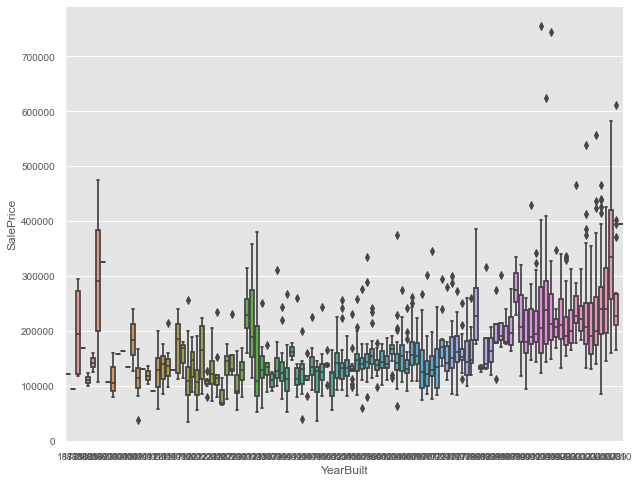

In [17]:
# 箱型图是看异常值的，离群点

plt.figure(figsize=(10, 8))
sns.boxplot(train.YearBuilt, train.SalePrice)

(0.0, 800000.0)

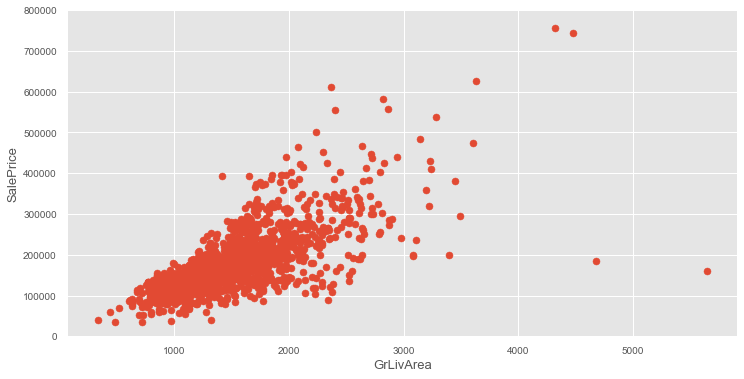

In [18]:
# 观察存在线型的关系

plt.figure(figsize=(12, 6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0, 800000)

In [19]:
from scipy.stats import norm, skew

In [20]:
# Deleting outliers
train = train.drop(train[(train["GrLivArea"] > 4000) &
                         (train["SalePrice"] < 300000)].index)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))


 mu = 180932.92 and sigma = 79467.79



In [21]:
from scipy import stats

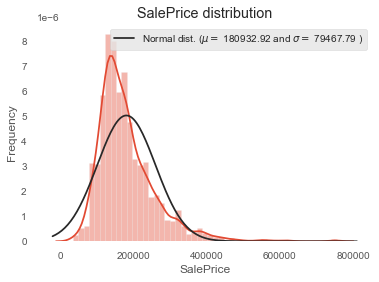

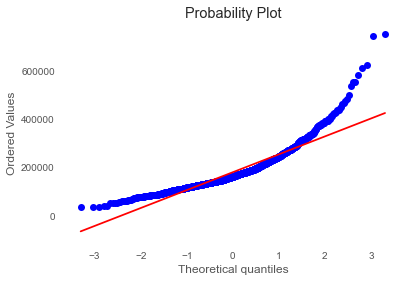


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'SalePrice distribution')

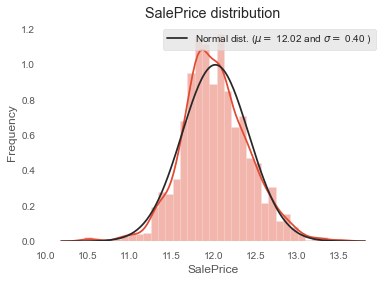

In [22]:
sns.distplot(train["SalePrice"], fit=norm)

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
    loc="best")
ax = plt.axes()
ax.set_facecolor("white")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

# Get also the QQ-plot
fig = plt.figure()
ax = fig.add_subplot()
ax.set_facecolor("white")
res = stats.probplot(train["SalePrice"], plot=plt)
plt.show()

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution
sns.distplot(train["SalePrice"], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train["SalePrice"])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

# Now plot the distribution
plt.legend(
    ["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )".format(mu, sigma)],
    loc="best")
ax = plt.axes()
ax.set_facecolor("white")
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

In [27]:
full = pd.concat([train, test]).reset_index(drop=True)

full.drop(["SalePrice"], axis=1, inplace=True)
print("all_data size is : {}".format(full.shape))
# full.info()

all_data size is : (2917, 79)


## 数据清洗

In [28]:
from scipy.stats import skew  # 偏度

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline  # 构建管道
from sklearn.preprocessing import Imputer, RobustScaler, StandardScaler

from sklearn.preprocessing import LabelEncoder  # 去除异常值与数据标准化; 标签编码

In [29]:
miss = full.isnull().sum()  # 统计出空值的个数
miss[miss > 0].sort_values(ascending=True)  # 由低到高排好序

TotalBsmtSF        1
GarageArea         1
GarageCars         1
KitchenQual        1
Electrical         1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
SaleType           1
Exterior1st        1
Exterior2nd        1
Functional         2
Utilities          2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtCond          82
BsmtExposure      82
GarageType       157
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
LotFrontage      486
FireplaceQu     1420
Fence           2346
Alley           2719
MiscFeature     2812
PoolQC          2908
dtype: int64

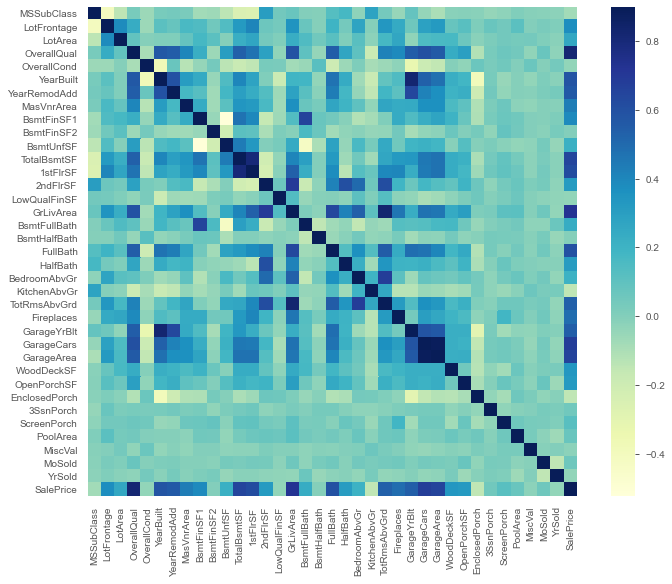

In [30]:
# Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap="YlGnBu", vmax=0.9, square=True)

In [31]:
full["FireplaceQu"] = full["FireplaceQu"].fillna("None")

full["PoolQC"] = full["PoolQC"].fillna("None")

full["MiscFeature"] = full["MiscFeature"].fillna("None")

full["Alley"] = full["Alley"].fillna("None")

full["Fence"] = full["Fence"].fillna("None")

# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
full["LotFrontage"] = full.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [32]:
for col in ("GarageType", "GarageFinish", "GarageQual", "GarageCond"):
    full[col] = full[col].fillna("None")

for col in ("GarageYrBlt", "GarageArea", "GarageCars"):
    full[col] = full[col].fillna(0)

for col in (
        "BsmtFinSF1",
        "BsmtFinSF2",
        "BsmtUnfSF",
        "TotalBsmtSF",
        "BsmtFullBath",
        "BsmtHalfBath",
):
    full[col] = full[col].fillna(0)

for col in ("BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2"):
    full[col] = full[col].fillna("None")

In [33]:
full["MasVnrType"] = full["MasVnrType"].fillna("None")
full["MasVnrArea"] = full["MasVnrArea"].fillna(0)

full["MSZoning"] = full["MSZoning"].fillna(full["MSZoning"].mode()[0])

full = full.drop(["Utilities"], axis=1)

full["Functional"] = full["Functional"].fillna("Typ")

full["Electrical"] = full["Electrical"].fillna(full["Electrical"].mode()[0])

full["KitchenQual"] = full["KitchenQual"].fillna(full["KitchenQual"].mode()[0])

full["Exterior1st"] = full["Exterior1st"].fillna(full["Exterior1st"].mode()[0])
full["Exterior2nd"] = full["Exterior2nd"].fillna(full["Exterior2nd"].mode()[0])

full["SaleType"] = full["SaleType"].fillna(full["SaleType"].mode()[0])
full["MSSubClass"] = full["MSSubClass"].fillna("None")

In [13]:
# MSSubClass=The building class
full["MSSubClass"] = full["MSSubClass"].apply(str)

# Changing OverallCond into a categorical variable
full["OverallCond"] = full["OverallCond"].astype(str)

# Year and month sold are transformed into categorical features.
full["YrSold"] = full["YrSold"].astype(str)
full["MoSold"] = full["MoSold"].astype(str)

In [34]:
from sklearn.preprocessing import LabelEncoder

cols = (
    "FireplaceQu",
    "BsmtQual",
    "BsmtCond",
    "GarageQual",
    "GarageCond",
    "ExterQual",
    "ExterCond",
    "HeatingQC",
    "PoolQC",
    "KitchenQual",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
    "BsmtExposure",
    "GarageFinish",
    "LandSlope",
    "LotShape",
    "PavedDrive",
    "Street",
    "Alley",
    "CentralAir",
    "MSSubClass",
    "OverallCond",
    "YrSold",
    "MoSold",
)
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(full[c].values))
    full[c] = lbl.transform(list(full[c].values))

# shape
print("Shape full: {}".format(full.shape))

Shape full: (2917, 78)


In [35]:
# Adding total sqfootage feature
full["TotalSF"] = full["TotalBsmtSF"] + full["1stFlrSF"] + full["2ndFlrSF"]
full["Bsmt"] = full["BsmtFinSF1"] + full["BsmtFinSF2"] + full["BsmtUnfSF"]
full["Rooms"] = full["FullBath"] + full["TotRmsAbvGrd"]
full["PorchArea"] = (full["OpenPorchSF"] + full["EnclosedPorch"] +
                     full["3SsnPorch"] + full["ScreenPorch"])
full["TotalPlace"] = (full["TotalBsmtSF"] + full["1stFlrSF"] +
                      full["2ndFlrSF"] + full["GarageArea"] +
                      full["OpenPorchSF"] + full["EnclosedPorch"] +
                      full["3SsnPorch"] + full["ScreenPorch"])
full["TotalArea"] = (full["TotalBsmtSF"] + full["1stFlrSF"] + full["2ndFlrSF"] +
                     full["GarageArea"])

In [41]:
full["TotalArea"]

0       3114.0
1       2984.0
2       3314.0
3       3115.0
4       4179.0
         ...  
2912    1638.0
2913    1924.0
2914    3024.0
2915    1882.0
2916    3646.0
Name: TotalArea, Length: 2917, dtype: float64

In [42]:
numeric_feats = full.dtypes[full.dtypes != "object"].index
numeric_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'Bsmt',
       'Rooms', 'PorchArea', 'TotalPlace', 'TotalArea'],
      dtype='object')

In [44]:
# Check the skew of all numerical features
skewed_feats = (
    full[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(
        ascending=False))
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({"Skew": skewed_feats})
skewness


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
...,...
GarageCond,-3.594290
GarageYrBlt,-3.904632
Functional,-4.054126
Street,-15.494756


In [45]:
skewness = skewness[abs(skewness) > 0.75]

print("There are {} skewed numerical features to Box Cox transform".format(
    skewness.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    # full[feat] += 1
    full[feat] = boxcox1p(full[feat], lam)

# full[skewed_features] = np.log1p(full[skewed_features])

full = pd.get_dummies(full)
print(full.shape)

There are 64 skewed numerical features to Box Cox transform
(2917, 225)


In [47]:
full["TotalSF"]

0       14.976591
1       14.923100
2       15.149678
3       14.857121
4       15.852312
          ...    
2912    13.567978
2913    13.567978
2914    14.824355
2915    13.993617
2916    15.485273
Name: TotalSF, Length: 2917, dtype: float64

In [48]:
ntrain = train.shape[0]

train = full[:ntrain]
test = full[ntrain:]

In [49]:
train["TotalSF"]

0       14.976591
1       14.923100
2       15.149678
3       14.857121
4       15.852312
          ...    
1453    15.019350
1454    16.118017
1455    16.000045
1456    14.418948
1457    14.907678
Name: TotalSF, Length: 1458, dtype: float64

In [19]:
# # Check remaining missing values if any
# full_na = (full.isnull().sum() / len(full)) * 100
# full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)
# missing_data = pd.DataFrame({"Missing Ratio": full_na})
# missing_data.head()

,Missing Ratio


## Model

In [50]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, LassoLarsIC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Validation function
n_folds = 5
# train = StandardScaler().fit(train).transform(train)


def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(
        model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [51]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(),
                     ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features="sqrt",
    min_samples_leaf=15,
    min_samples_split=10,
    loss="huber",
    random_state=5,
)

model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.4603,
    gamma=0.0468,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1.7817,
    n_estimators=2200,
    reg_alpha=0.4640,
    reg_lambda=0.8571,
    subsample=0.5213,
    silent=1,
    random_state=7,
    nthread=-1,
)

model_lgb = lgb.LGBMRegressor(
    objective="regression",
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=720,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.2319,
    feature_fraction_seed=9,
    bagging_seed=9,
    min_data_in_leaf=6,
    min_sum_hessian_in_leaf=11,
)

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)

ElasticNet score: 0.1115 (0.0074)

Kernel Ridge score: 0.1162 (0.0073)

Gradient Boosting score: 0.1169 (0.0080)

Xgboost score: 0.1170 (0.0060)

LGBM score: 0.1168 (0.0070)



In [54]:
BayR = BayesianRidge()

score = rmsle_cv(BayR)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

LGBM score: 0.1161 (0.0080)



In [52]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):

    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [61]:
averaged_models = AveragingModels(models=(ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0073)



In [55]:
# averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso, BayR))

# score = rmsle_cv(averaged_models)
# print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1095 (0.0075)



In [56]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):

    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X)
                             for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [57]:
# stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, BayR),
#                                                  meta_model = lasso)

# score = rmsle_cv(stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1082 (0.0073)


In [62]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, GBoost,
                                                              KRR),
                                                 meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(
    score.mean(), score.std()))

Stacking Averaged models score: 0.1082 (0.0073)


In [70]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
averaged_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y_train, averaged_train_pred))

0.07870196247223475


In [63]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))
"""RMSE on the entire Train data when averaging"""
print("RMSLE score on train data:")
print(
    rmsle(
        y_train,
        stacked_train_pred * 0.15 + xgb_train_pred * 0.15 +
        lgb_train_pred * 0.70,
    ))

0.07893643318175408
0.078285287880521
0.0715184506939234
RMSLE score on train data:
0.0756165856814921


In [65]:
"""RMSE on the entire Train data when averaging"""
print("RMSLE score on train data:")
print(
    rmsle(
        y_train,
        stacked_train_pred * 0.70 + xgb_train_pred * 0.15 + lgb_train_pred * 0.15,
    ))

RMSLE score on train data:
0.0718077768401914


In [72]:
ensemble = stacked_pred*0.70  + xgb_pred*0.15 + lgb_pred*0.15

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

## Not important

## 特征筛选

In [49]:
class labelenc(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    # 对三个年份来进行一个标签编码,这里可以随便自己添加
    def transform(self, X):
        lab = LabelEncoder()
        pass
        return X


class skew_dummies(BaseEstimator, TransformerMixin):

    def __init__(self, skew=0.5):  # 偏度
        self.skew = skew

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_numeric = X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index

        # 求对数，进一步让他更符合正态分布
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)  # 独热编码
        return X

In [50]:
pipe = Pipeline([  ##构建管道的意思
    ("labenc", labelenc()),
    ("skew_dummies", skew_dummies(skew=2)),
])

full2 = full.copy()
pipeline_data = pipe.fit_transform(full2)
pipeline_data.shape

(2917, 167)

In [51]:
n_train = train.shape[0]  # 训练集的行数

X = pipeline_data[:n_train]  # 取出处理之后的训练集
X_scaled = StandardScaler().fit(X).transform(X)  # 做转换

y = train.SalePrice
y_log = np.log(train.SalePrice)  # 更符合正态分布

### Lasso

In [52]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001)
lasso.fit(X_scaled, y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

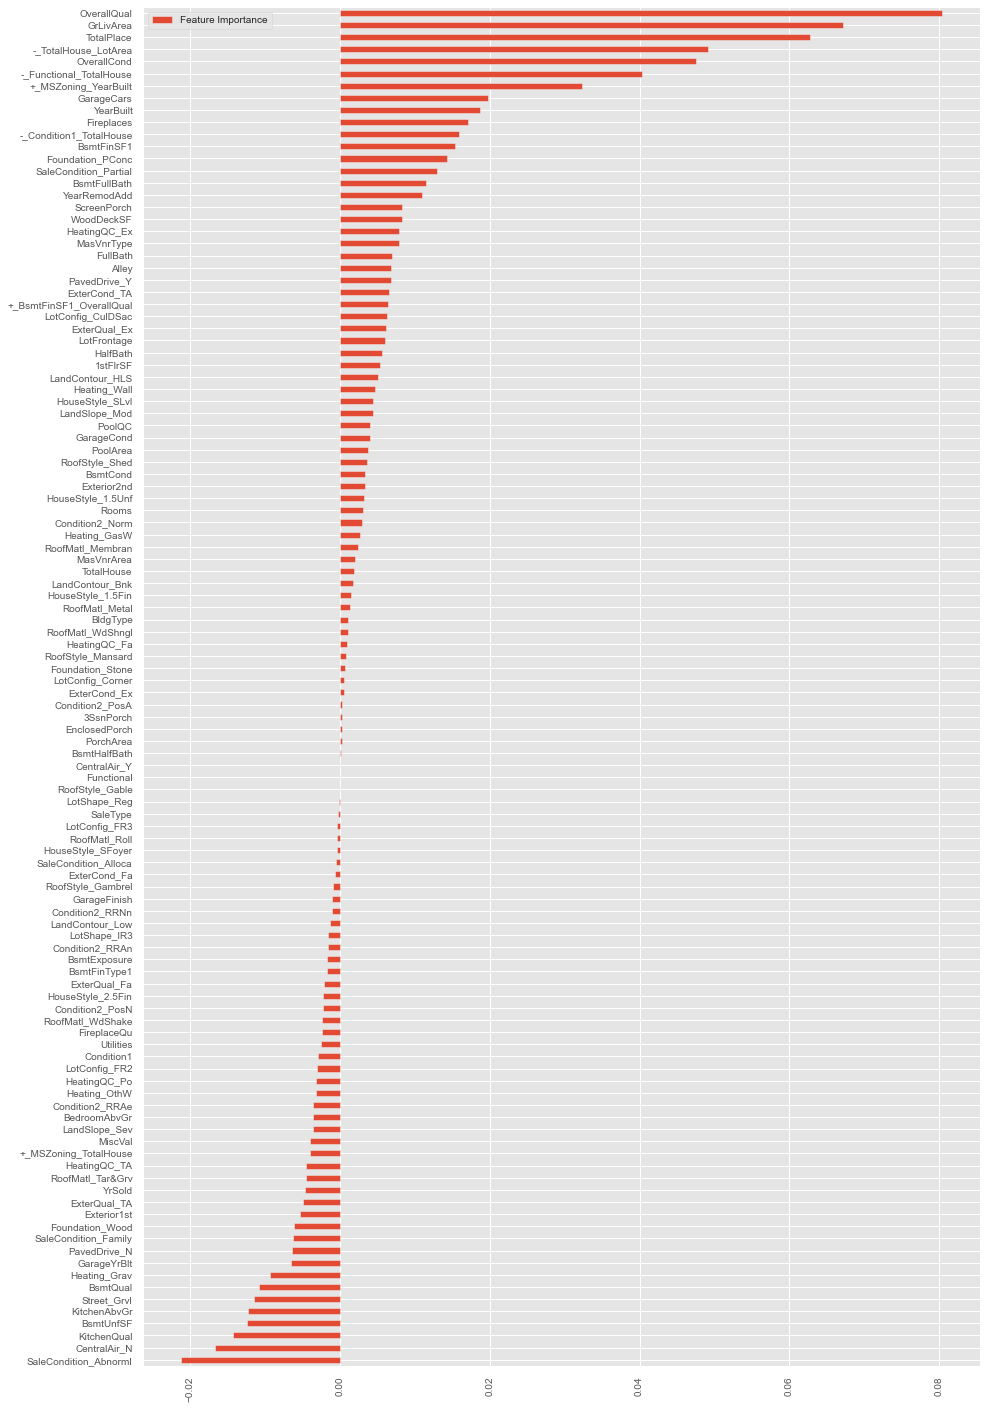

In [53]:
feat_lasso = pd.DataFrame({"Feature Importance": lasso.coef_},
                          index=pipeline_data.columns)
feat_lasso.sort_values("Feature Importance", ascending=False)
feat_lasso[feat_lasso["Feature Importance"] != 0].sort_values(
    "Feature Importance").plot(kind="barh", figsize=(15, 25))

plt.xticks(rotation=90)
plt.show()

In [58]:
# set(feat_lasso[feat_lasso["Feature Importance"] != 0].index) - set(full.columns).intersection(set(feat_lasso[feat_lasso["Feature Importance"] != 0].index))

### 组合

In [40]:
class add_feature(BaseEstimator, TransformerMixin):

    def __init__(self, additional=False):
        self.additional = additional

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.additional == False:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
            X["TotalArea"] = (X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] +
                              X["GarageArea"])

        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
            X["TotalArea"] = (X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] +
                              X["GarageArea"])

            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_MSZoning_TotalHouse"] = X["MSZoning"] * X["TotalHouse"]
            X["+_MSZoning_OverallQual"] = X["MSZoning"] + X["OverallQual"]
            X["+_MSZoning_YearBuilt"] = X["MSZoning"] + X["YearBuilt"]
            X["+_Neighborhood_TotalHouse"] = X["Neighborhood"] * X["TotalHouse"]
            X["+_Neighborhood_OverallQual"] = X["Neighborhood"] + X[
                "OverallQual"]
            X["+_Neighborhood_YearBuilt"] = X["Neighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

            X["-_Functional_TotalHouse"] = X["Functional"] * X["TotalHouse"]
            X["-_Functional_OverallQual"] = X["Functional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_Condition1_TotalHouse"] = X["Condition1"] * X["TotalHouse"]
            X["-_Condition1_OverallQual"] = X["Condition1"] + X["OverallQual"]

            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"] + X["TotRmsAbvGrd"]
            X["PorchArea"] = (X["OpenPorchSF"] + X["EnclosedPorch"] +
                              X["3SsnPorch"] + X["ScreenPorch"])
            X["TotalPlace"] = (X["TotalBsmtSF"] + X["1stFlrSF"] +
                               X["2ndFlrSF"] + X["GarageArea"] +
                               X["OpenPorchSF"] + X["EnclosedPorch"] +
                               X["3SsnPorch"] + X["ScreenPorch"])

            return X

In [55]:
pipe = Pipeline([  # 把后面的东西加到管道里面来
    ("labenc", labelenc()),
    ("add_feature", add_feature(additional=True)),
    ("skew_dummies", skew_dummies(skew=4)),
])

pipeline_data = pipe.fit_transform(full)

In [56]:
pipeline_data = pipeline_data.loc[:,
                                  list(feat_lasso[
                                      feat_lasso["Feature Importance"] != 0].
                                       index)]

In [57]:
n_train = train.shape[0]

X = pipeline_data[:n_train]
X_scaled = StandardScaler().fit(X).transform(X)

y = train.SalePrice
y_log = np.log(train.SalePrice)

# 得到测试集
test_X = pipeline_data[n_train:]
test_X_scaled = StandardScaler().fit_transform(test_X)

## Model

In [58]:
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    Lasso,
    LinearRegression,
    Ridge,
    SGDRegressor,
)
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

In [59]:
# 定义交叉验证的策略，以及评估函数
def rmse_cv(model, X, y):
    rmse = np.sqrt(
        -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [60]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha=0.01, max_iter=10000),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    LinearSVR(),
    ElasticNet(alpha=0.001, max_iter=10000),
    SGDRegressor(max_iter=1000, tol=1e-3),
    BayesianRidge(),
    KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5),
    ExtraTreesRegressor(),
    XGBRegressor(),
]

In [61]:
names = [
    "LR",
    "Ridge",
    "Lasso",
    "RF",
    "GBR",
    "SVR",
    "LinSVR",
    "Ela",
    "SGD",
    "Bay",
    "Ker",
    "Extra",
    "Xgb",
]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))

LR: 1042895582262.484985, 1057967869961.9542
Ridge: 0.124245, 0.0075
Lasso: 0.125983, 0.0061
RF: 0.140639, 0.0079
GBR: 0.126274, 0.0064
SVR: 0.183217, 0.0134
LinSVR: 1.137637, 0.4357
Ela: 0.124195, 0.0069
SGD: 6.591513, 5.5257
Bay: 0.123893, 0.0066
Ker: 0.121168, 0.0079
Extra: 0.141827, 0.0063
Xgb: 0.133785, 0.0064


In [62]:
class grid:

    def __init__(self, model):
        self.model = model

    def grid_get(self, X, y, param_grid):
        grid_search = GridSearchCV(self.model,
                                   param_grid,
                                   cv=5,
                                   scoring="neg_mean_squared_error")
        grid_search.fit(X, y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_["mean_test_score"] = np.sqrt(
            grid_search.cv_results_["mean_test_score"])
        print(
            pd.DataFrame(grid_search.cv_results_)[[
                "params", "mean_test_score", "std_test_score"
            ]])

In [63]:
grid(Lasso()).grid_get(
    X_scaled,
    y_log,
    {
        "alpha": [0.0004, 0.0005, 0.0007, 0.0006, 0.0009, 0.0008],
        "max_iter": [10000]
    },
)

{'alpha': 0.0004, 'max_iter': 10000} 0.12439199773646599
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}              NaN        0.001753
1  {'alpha': 0.0005, 'max_iter': 10000}              NaN        0.001737
2  {'alpha': 0.0007, 'max_iter': 10000}              NaN        0.001700
3  {'alpha': 0.0006, 'max_iter': 10000}              NaN        0.001722
4  {'alpha': 0.0009, 'max_iter': 10000}              NaN        0.001673
5  {'alpha': 0.0008, 'max_iter': 10000}              NaN        0.001689


In [64]:
grid(Ridge()).grid_get(X_scaled, y_log,
                       {"alpha": [35, 40, 45, 50, 55, 60, 65, 70, 80, 90]})

{'alpha': 90} 0.12390671306977306
          params  mean_test_score  std_test_score
0  {'alpha': 35}              NaN        0.001691
1  {'alpha': 40}              NaN        0.001679
2  {'alpha': 45}              NaN        0.001669
3  {'alpha': 50}              NaN        0.001660
4  {'alpha': 55}              NaN        0.001652
5  {'alpha': 60}              NaN        0.001645
6  {'alpha': 65}              NaN        0.001639
7  {'alpha': 70}              NaN        0.001633
8  {'alpha': 80}              NaN        0.001623
9  {'alpha': 90}              NaN        0.001616


In [65]:
grid(SVR()).grid_get(
    X_scaled,
    y_log,
    {
        "C": [11, 12, 13, 14, 15],
        "kernel": ["rbf"],
        "gamma": [0.0003, 0.0004],
        "epsilon": [0.008, 0.009],
    },
)

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, 'kernel': 'rbf'} 0.12230953139440992
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...              NaN   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...              NaN   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...              NaN   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...              NaN   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...              NaN   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...              NaN   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...              NaN   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...              NaN   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...              NaN   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...              NaN   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...              NaN   
11  {'C': 13, 'epsilon': 0.009

In [66]:
param_grid = {
    "alpha": [0.2, 0.3, 0.4, 0.5],
    "kernel": ["polynomial"],
    "degree": [3],
    "coef0": [0.8, 1, 1.2],
}  # 定义好的参数，用字典来表示
grid(KernelRidge()).grid_get(X_scaled, y_log, param_grid)

{'alpha': 0.5, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.13545786406690216
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...              NaN   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...              NaN   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...              NaN   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...              NaN   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...              NaN   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...              NaN   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...              NaN   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...              NaN   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...              NaN   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...              NaN   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...              NaN   
11  {'alpha': 0.5, 'coef0'

In [67]:
grid(ElasticNet()).grid_get(
    X_scaled,
    y_log,
    {
        "alpha": [0.0005, 0.0008, 0.004, 0.005],
        "l1_ratio": [0.08, 0.1, 0.3, 0.5, 0.7],
        "max_iter": [10000],
    },
)

{'alpha': 0.005, 'l1_ratio': 0.7, 'max_iter': 10000} 0.12309328394717067
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...              NaN   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...              NaN   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...              NaN   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...              NaN   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...              NaN   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...              NaN   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...              NaN   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...              NaN   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...              NaN   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...              NaN   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...              NaN   
11  {'alpha': 0.004, 'l1_ratio': 0.1, '

In [68]:
class AverageWeight(BaseEstimator, RegressorMixin):

    def __init__(self, mod, weight):
        self.mod = mod  ##模型的个数
        self.weight = weight  ##权重

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X, y)
        return self

    def predict(self, X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # 针对于每一个数据点，单一的模型是乘以权重，然后加起来
        for data in range(pred.shape[1]):
            single = [
                pred[model, data] * weight
                for model, weight in zip(range(pred.shape[0]), self.weight)
            ]
            w.append(np.sum(single))
        return w

In [69]:
lasso = Lasso(alpha=0.0004, max_iter=10000)
ridge = Ridge(alpha=90)
svr = SVR(gamma=0.0003, kernel="rbf", C=15, epsilon=0.009)
ker = KernelRidge(alpha=0.5, kernel="polynomial", degree=3, coef0=1.2)
ela = ElasticNet(alpha=0.005, l1_ratio=0.7, max_iter=10000)
bay = BayesianRidge()

In [71]:
w1 = 0.24
w2 = 0.2
w3 = 0.24
w4 = 0.02
w5 = 0.1
w6 = 0.2

weight_avg = AverageWeight(mod=[lasso, ridge, svr, ker, ela, bay],
                           weight=[w1, w2, w3, w4, w5, w6])

cv_res = rmse_cv(weight_avg, X_scaled, y_log)

print(cv_res)
print(cv_res.mean())

[0.11577233 0.13047749 0.12832588 0.11465141 0.11678236]
0.12120189097623409


### stack

In [73]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):

    def __init__(self, mod, meta_model):
        self.mod = mod
        self.meta_model = meta_model  # 元模型
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)

    def fit(self, X, y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))

        for i, model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X, y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index, i] = renew_model.predict(X[val_index])

        self.meta_model.fit(oof_train, y)  # 元模型
        return self

    def predict(self, X):
        whole_test = np.column_stack([
            np.column_stack(model.predict(X)
                            for model in single_model).mean(axis=1)
            for single_model in self.saved_model
        ])
        return self.meta_model.predict(whole_test)

    def get_oof(self, X, y, test_X):
        oof = np.zeros((X.shape[0], len(self.mod)))
        test_single = np.zeros((test_X.shape[0], 5))
        test_mean = np.zeros((test_X.shape[0], len(self.mod)))
        for i, model in enumerate(self.mod):
            for j, (train_index, val_index) in enumerate(self.kf.split(X, y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index], y[train_index])
                oof[val_index, i] = clone_model.predict(X[val_index])
                test_single[:, j] = clone_model.predict(test_X)
            test_mean[:, i] = test_single.mean(axis=1)
        return oof, test_mean

In [79]:
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1, 1)).ravel()

stack_model = stacking(mod=[lasso, ridge, svr, ker, ela, bay], meta_model=bay)

print(rmse_cv(stack_model, a, b))
print(rmse_cv(stack_model, a, b).mean())

D:\ProgramData\envs\nlpLearning\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
D:\ProgramData\envs\nlpLearning\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


[0.11522243 0.12764919 0.12667055 0.11501122 0.11340148]
0.11959097644216768


In [75]:
X_train_stack, X_test_stack = stack_model.get_oof(a, b, test_X_scaled)

In [76]:
X_train_add = np.hstack((a, X_train_stack))
X_test_add = np.hstack((test_X_scaled, X_test_stack))

In [77]:
# Non sense
print(rmse_cv(stack_model, X_train_add, b))
print(rmse_cv(stack_model, X_train_add, b).mean())

[0.10311294 0.1183771  0.11460883 0.10173203 0.10887826]
0.10934183122947227


In [84]:
stack_model.fit(a, b)

stacking(meta_model=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
     mod=[Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=90, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [88]:
# pred = np.exp(stack_model.predict(test_X_scaled))
# result = pd.DataFrame({"Id": test.Id, "SalePrice": pred})
# result.to_csv("submission.csv", index=False)